In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import metrics
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from itertools import product
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier

import statsmodels.api as sm

import datetime


In [2]:
data = pd.read_csv("startupData/ks-projects-201801.csv")
df= data.copy()
print(df.head())

           ID                                               name  \
0  1000002330                    The Songs of Adelaide & Abullah   
1  1000003930      Greeting From Earth: ZGAC Arts Capsule For ET   
2  1000004038                                     Where is Hank?   
3  1000007540  ToshiCapital Rekordz Needs Help to Complete Album   
4  1000011046  Community Film Project: The Art of Neighborhoo...   

         category main_category currency    deadline     goal  \
0          Poetry    Publishing      GBP  2015-10-09   1000.0   
1  Narrative Film  Film & Video      USD  2017-11-01  30000.0   
2  Narrative Film  Film & Video      USD  2013-02-26  45000.0   
3           Music         Music      USD  2012-04-16   5000.0   
4    Film & Video  Film & Video      USD  2015-08-29  19500.0   

              launched  pledged     state  backers country  usd pledged  \
0  2015-08-11 12:12:28      0.0    failed        0      GB          0.0   
1  2017-09-02 04:43:57   2421.0    failed       15

## Descriptive statistics (+some preprocessing)

In [3]:
df1 = df.copy()
df = df.drop(columns = ['pledged','goal','usd pledged'])
df = df.dropna()
df.shape

(378657, 12)

In [4]:
df['nameLength'] = df['name'].str.len()

df['currency'].replace({'USD':'USD',
 'GBP':'GBP',
 'EUR':'EUR',
 'CAD':'CAD',
 'AUD':'AUD',
 'SEK':'other',
 'MXN':'other',
 'NZD':'other',
 'DKK':'other',
 'CHF':'other',
 'NOK':'other',
 'HKD':'other',
 'SGD':'other',
 'JPY':'other'}, inplace=True)

#date and time data to float for easier regression
df['launched']=pd.to_datetime(df['launched']).dt.date
df['launchTime'] = (df['launched'] - df['launched'].min())  / np.timedelta64(1,'D')

df['deadlineDum']=pd.to_datetime(df['deadline']).dt.date
df['deadlineTime'] = (df['deadlineDum'] - df['launched'].min())  / np.timedelta64(1,'D')

df['projectLength'] = df['deadlineTime'] - df['launchTime']

## Training time! (cont)

In [5]:
# deep copy datasets, keeping dfOri unchanged
dfOri = df.copy()
df = dfOri.copy()
df = df.drop(columns = ['ID','deadline','launched','deadlineDum'],errors='ignore' )

In [6]:
# train test split
df_rest, df_test = train_test_split(df,test_size=0.1, random_state=123, stratify=df['state'])
df_train, df_val = train_test_split(df_rest, test_size=0.2, random_state=123,stratify=df_rest['state'])
print(df_test['state'].value_counts())
print(df_train['state'].value_counts())
print(df_val['state'].value_counts())

failed        19772
successful    13396
canceled       3878
undefined       356
live            280
suspended       184
Name: state, dtype: int64
failed        142355
successful     96447
canceled       27921
undefined       2565
live            2015
suspended       1329
Name: state, dtype: int64
failed        35589
successful    24113
canceled       6980
undefined       641
live            504
suspended       332
Name: state, dtype: int64


### Dependent variable = state (all categories, except canceled since this one has no information on usd goal and pledge)

In [7]:
#df1 has all the thing needed for this part
dfS_train = df_train.copy()
dfS_train = dfS_train[['name','main_category','state', 'backers','usd_goal_real', 'nameLength', 'launchTime', 'deadlineTime', 'projectLength','currency']]
dfS_train = dfS_train[dfS_train['state'] != 'canceled']
dfS_train.shape


(244711, 10)

In [8]:
dfS_val = df_val.copy()
dfS_val = dfS_val[['name','main_category','state', 'backers','usd_goal_real', 'nameLength', 'launchTime', 'deadlineTime', 'projectLength','currency']]
dfS_val = dfS_val[dfS_val['state'] != 'canceled']
dfS_val.shape


(61179, 10)

In [9]:
# Category
mainCategory = dfS_train['main_category'].value_counts().keys().to_list()
print(mainCategory)
currency = dfS_train['currency'].value_counts().keys().to_list()
print(currency)

['Film & Video', 'Music', 'Publishing', 'Games', 'Technology', 'Art', 'Design', 'Food', 'Fashion', 'Theater', 'Comics', 'Photography', 'Crafts', 'Journalism', 'Dance']
['USD', 'GBP', 'EUR', 'CAD', 'other', 'AUD']


#### Only have numerical features (excluding the "name" feature)


In [10]:
X_train1 = dfS_train.drop(columns=['state','name'])
y_train1 = dfS_train['state']
X_val1 = dfS_val.drop(columns=['state','name'])
y_val1 = dfS_val['state']

enc1 = OneHotEncoder(categories=[mainCategory,currency],drop = 'first')

prepro1 = make_column_transformer((enc1, ['main_category','currency']),
                                      (StandardScaler(), ['backers','usd_goal_real', 'nameLength', 'launchTime', 'deadlineTime', 'projectLength']))
#see if it is working
print(prepro1.fit_transform(X_train1).toarray()[0])


[ 1.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.22024098 -0.02099224  1.1121904   0.22027868  0.21534828
 -0.11259926]


In [23]:
model1 = make_pipeline(prepro1, LogisticRegression(max_iter=200, multi_class='auto'))

model1.fit(X_train1, y_train1)

predictVal = model1.score(X_val1,y_val1)
predictTrain = model1.score(X_train1,y_train1)
print('The accuracy of the model in training set: ' + str(predictTrain*100)+ ' %')
print('The accuracy of the model in validation set: ' + str(predictVal*100)+ ' %')

/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The accuracy of the model in training set: 86.30384412633678 %
The accuracy of the model in validation set: 86.30575851190768 %


In [26]:
max_iter = [1,5,10,100,200,300,400,500,800,1000]

results = np.zeros((len(max_iter),2))
converg = np.zeros((len(max_iter)))
for i in range(len(max_iter)):
    model = make_pipeline(prepro1, LogisticRegression(max_iter=max_iter[i], multi_class='auto'))
    model.fit(X_train1, y_train1)

    results[i,0] = model.score(X_val1,y_val1)
    results[i,1] = model.score(X_train1,y_train1)
    converg[i] = model[1].n_iter_
    print(f'validation score for max iter = {max_iter[i]} is {results[i,0]}')

/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


validation score for max iter = 1 is 0.6033769757596561


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


validation score for max iter = 5 is 0.6785334837117312


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


validation score for max iter = 10 is 0.7519246800372676


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


validation score for max iter = 100 is 0.85859526961866


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


validation score for max iter = 200 is 0.8630575851190768


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


validation score for max iter = 300 is 0.8638748590202521


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


validation score for max iter = 400 is 0.8641854231026986


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


validation score for max iter = 500 is 0.8646430964873568


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


validation score for max iter = 800 is 0.8649700060478269


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


validation score for max iter = 1000 is 0.8651334608280619


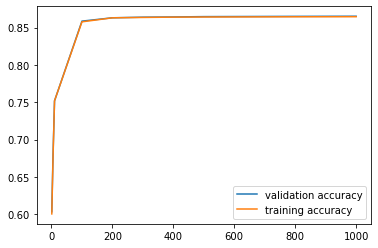

In [27]:
plt.plot(max_iter, results[:,0], label = 'validation accuracy')
plt.plot(max_iter, results[:,1], label = 'training accuracy')
plt.legend()
plt.show()

at 1000 max_iter, the model does not converge but it seems to hit the plateau at 200, meaning it could be used as early stop

Now we start to hypertune some other parameters

In [30]:
#Simple hypertune
solvers = ['newton-cg', 'lbfgs', 'liblinear','sag', 'saga']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1,0.01]
#running all specification and comparing their validation accuracy
results = np.zeros((40,2))
i = 0
for sol in solvers:
    for c in c_values:
        for pen in penalty:
            begin = time.time()
            logic = LogisticRegression(solver = sol, penalty = pen, C=c,max_iter=200,multi_class='auto')
            model = make_pipeline(prepro1, logic)
            model.fit(X_train1, y_train1)
            results[i,0] = model.score(X_val1,y_val1)
            results[i,1] = model.score(X_train1,y_train1)
            i+=1
            end = time.time()
            print(f'index for sovler {sol},c value {c} and pennalty {pen} is {i}, run time {end-begin}')
        

index for sovler newton-cg,c value 100 and pennalty l2 is 1, run time 344.42244505882263
index for sovler newton-cg,c value 10 and pennalty l2 is 2, run time 171.33765506744385
index for sovler newton-cg,c value 1.0 and pennalty l2 is 3, run time 83.91687083244324
index for sovler newton-cg,c value 0.1 and pennalty l2 is 4, run time 43.98563289642334
index for sovler newton-cg,c value 0.01 and pennalty l2 is 5, run time 27.969404935836792


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


index for sovler lbfgs,c value 100 and pennalty l2 is 6, run time 21.655200004577637


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


index for sovler lbfgs,c value 10 and pennalty l2 is 7, run time 21.75910496711731


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


index for sovler lbfgs,c value 1.0 and pennalty l2 is 8, run time 21.526055097579956


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


index for sovler lbfgs,c value 0.1 and pennalty l2 is 9, run time 21.036686897277832
index for sovler lbfgs,c value 0.01 and pennalty l2 is 10, run time 17.528189182281494


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


index for sovler liblinear,c value 100 and pennalty l2 is 11, run time 26.947352170944214
index for sovler liblinear,c value 10 and pennalty l2 is 12, run time 15.865797281265259


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


index for sovler liblinear,c value 1.0 and pennalty l2 is 13, run time 17.984627962112427
index for sovler liblinear,c value 0.1 and pennalty l2 is 14, run time 9.352125883102417
index for sovler liblinear,c value 0.01 and pennalty l2 is 15, run time 6.167003870010376


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


index for sovler sag,c value 100 and pennalty l2 is 16, run time 36.56070303916931


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


index for sovler sag,c value 10 and pennalty l2 is 17, run time 36.506760120391846


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


index for sovler sag,c value 1.0 and pennalty l2 is 18, run time 36.5547513961792


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


index for sovler sag,c value 0.1 and pennalty l2 is 19, run time 44.23740530014038


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


index for sovler sag,c value 0.01 and pennalty l2 is 20, run time 37.30616092681885


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


index for sovler saga,c value 100 and pennalty l2 is 21, run time 38.70933723449707


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


index for sovler saga,c value 10 and pennalty l2 is 22, run time 38.44634175300598


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


index for sovler saga,c value 1.0 and pennalty l2 is 23, run time 38.354326009750366


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


index for sovler saga,c value 0.1 and pennalty l2 is 24, run time 38.293540239334106


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


index for sovler saga,c value 0.01 and pennalty l2 is 25, run time 38.4523868560791


In [33]:

print(np.concatenate((np.arange(1,26).reshape(25,1), results[:25,:]),axis=1))

[[ 1.          0.88602298  0.88572643]
 [ 2.          0.88277023  0.88159094]
 [ 3.          0.86506808  0.86452591]
 [ 4.          0.83167427  0.83224293]
 [ 5.          0.79442292  0.79549755]
 [ 6.          0.88659507  0.88651103]
 [ 7.          0.88116837  0.88063471]
 [ 8.          0.86305759  0.86303844]
 [ 9.          0.83170696  0.83230423]
 [10.          0.79445561  0.79549755]
 [11.          0.8615538   0.86092166]
 [12.          0.86145573  0.86076229]
 [13.          0.8440151   0.8438975 ]
 [14.          0.81830367  0.81879441]
 [15.          0.77972834  0.78062694]
 [16.          0.7771621   0.77774191]
 [17.          0.7771621   0.77773782]
 [18.          0.77712941  0.77769696]
 [19.          0.77676981  0.77718615]
 [20.          0.77142484  0.77209443]
 [21.          0.76143775  0.76141653]
 [22.          0.76140506  0.7614247 ]
 [23.          0.76138871  0.76137566]
 [24.          0.76119257  0.76106509]
 [25.          0.75860998  0.75829039]]


liblinear with l1 took too much time and converges much slower ==> not worth running

Other options


In [79]:
model1 = make_pipeline(prepro1, LogisticRegression(max_iter=200,penalty = 'none',multi_class='auto'))
begin = time.time()
model1.fit(X_train1, y_train1)
print(f'run time is {time.time()-begin}')
predictVal = model1.score(X_val1,y_val1)
predictTrain = model1.score(X_train1,y_train1)
print('The accuracy of the model in training set: ' + str(predictTrain*100)+ ' %')
print('The accuracy of the model in validation set: ' + str(predictVal*100)+ ' %')

/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


run time is 22.458029985427856
The accuracy of the model in training set: 88.39855993396291 %
The accuracy of the model in validation set: 88.37509602968339 %


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


index for c value 50 is 1, run time 30.245121955871582


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


index for c value 80 is 2, run time 24.23944592475891


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


index for c value 100 is 3, run time 26.92313289642334


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


index for c value 120 is 4, run time 25.680221796035767


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


index for c value 150 is 5, run time 23.441079139709473


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


index for c value 200 is 6, run time 22.809834003448486


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


index for c value 250 is 7, run time 24.29054307937622


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


index for c value 300 is 8, run time 22.404228687286377


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


index for c value 400 is 9, run time 25.75597310066223


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


index for c value 500 is 10, run time 29.57860779762268


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


index for c value 600 is 11, run time 31.350453853607178


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


index for c value 700 is 12, run time 31.867937088012695


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


index for c value 800 is 13, run time 35.39420413970947


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


index for c value 900 is 14, run time 25.56129789352417


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


index for c value 1000 is 15, run time 40.03594183921814


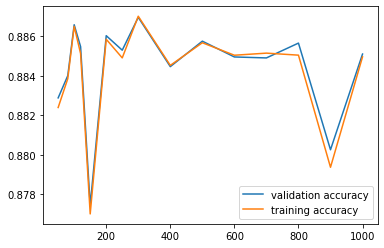

In [14]:
#Simple hypertune
c_values = [50, 80, 100,120, 150, 200, 250, 300, 400, 500, 600, 700,800, 900, 1000]
#running all specification and comparing their validation accuracy. Note that if liblinear is not worth running with l1,omitted then
results = np.zeros((len(c_values),2))
i = 0

for c in c_values:
    begin = time.time()
    logic = LogisticRegression(C=c,max_iter=200,multi_class='auto') #default lbfgs with l2 penalty
    model = make_pipeline(prepro1, logic)
    model.fit(X_train1, y_train1)
    results[i,0] = model.score(X_val1,y_val1)
    results[i,1] = model.score(X_train1,y_train1)
    i+=1
    end = time.time()
    print(f'index for c value {c} is {i}, run time {end-begin}')
    


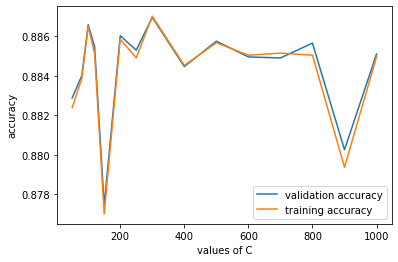

[[0.88288465 0.88239597]
 [0.88401249 0.88385892]
 [0.88659507 0.88651103]
 [0.88548358 0.88512981]
 [0.87742526 0.87699776]
 [0.88603933 0.88585719]
 [0.88530378 0.88491322]
 [0.88697102 0.88702592]
 [0.88447016 0.88453318]
 [0.88576145 0.88568148]
 [0.88496053 0.88504808]
 [0.88491149 0.88515432]
 [0.88566338 0.88505216]
 [0.88025303 0.87936382]
 [0.88510763 0.88496635]]


In [16]:
plt.plot(c_values, results[:,0], label = 'validation accuracy')
plt.plot(c_values, results[:,1], label = 'training accuracy')
plt.xlabel('values of C')
plt.ylabel('accuracy')
plt.legend()
plt.show()

print(results)

In [29]:
#pick model
model1 = make_pipeline(prepro1, LogisticRegression(max_iter=200,C=300,multi_class='auto'))

model1.fit(X_train1, y_train1)

predictVal = model1.score(X_val1,y_val1)
predictTrain = model1.score(X_train1,y_train1)
print('The accuracy of the model in training set: ' + str(predictTrain*100)+ ' %')
print('The accuracy of the model in validation set: ' + str(predictVal*100)+ ' %')

/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The accuracy of the model in training set: 88.70259203713769 %
The accuracy of the model in validation set: 88.69710194674644 %


In [30]:
print(model1[1].coef_)
print(model1[1].intercept_)


[[-5.56495758e-01  2.61850595e-01  3.13822009e+00  2.93745183e+00
   2.74153738e+00  2.80007009e+00  3.06289464e+00  3.10784195e+00
   1.26005572e+00  2.17182768e+00  2.22915829e+00  2.18211008e+00
   2.00125196e+00  1.53192655e+00 -1.13996748e-01  7.58232498e-02
  -1.44774268e-01  4.86389894e-03 -8.59515164e-02 -1.13326518e+01
   5.78822979e+01 -1.13216634e-01 -6.19851941e+00 -6.23366588e+00
  -2.18914910e-01]
 [-4.60773872e-01  2.82518511e-02  2.39173928e+00  2.40693968e+00
   3.05080456e+00  2.22597200e+00  1.96680180e+00  2.32934638e+00
   1.34951653e+00  1.20243197e+00  1.11523468e+00  1.59233835e+00
  -1.18635715e+00 -8.28295052e-01 -1.22574306e-01  1.95855058e-03
  -1.87648662e-02 -1.73279706e-01 -1.51693226e-01  1.90034067e+01
   5.78825073e+01 -1.88060241e-01  2.42351828e+01  2.44086961e+01
   1.55910136e+00]
 [-5.80024801e-01 -4.63220401e-01  1.52713420e+00  2.02175426e+00
   2.52808177e+00  1.96621044e+00  2.38401982e+00  2.30214324e+00
   1.78384306e+00  1.66769658e+00  1.6

#### Have extra text features (preprocessing the "name" feature)

In [11]:
X_train2 = dfS_train.drop(columns=['state'])
y_train2 = dfS_train['state']
X_val2 = dfS_val.drop(columns=['state'])
y_val2 = dfS_val['state']

textPrep = make_pipeline(CountVectorizer(lowercase=True),TfidfTransformer())
enc2 = OneHotEncoder(categories=[mainCategory,currency],drop = 'first')

prepro2 = make_column_transformer((textPrep,'name'),
    (enc2, ['main_category','currency']),
    (StandardScaler(), ['backers','usd_goal_real', 'nameLength', 'launchTime', 'deadlineTime', 'projectLength']))
#see if it is working
print(prepro2.fit_transform(X_train2).toarray()[0])

[ 0.          0.          0.         ...  0.22027868  0.21534828
 -0.11259926]


In [32]:
model2 = make_pipeline(prepro2, LogisticRegression(max_iter=700,multi_class='auto'))

model2.fit(X_train2, y_train2)

predictVal = model2.score(X_val2,y_val2)
predictTrain = model2.score(X_train2,y_train2)
print('The accuracy of the model in training set: ' + str(predictTrain*100)+ ' %')
print('The accuracy of the model in validation set: ' + str(predictVal*100)+ ' %')

/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The accuracy of the model in training set: 89.92239825753644 %
The accuracy of the model in validation set: 85.3740662645679 %


In [48]:
max_iter = [1,5,10,100,200,300,400,500,800,1000]

results2 = np.zeros((len(max_iter),2))
converg = np.zeros((len(max_iter)))
for i in range(len(max_iter)):
    model = make_pipeline(prepro2, LogisticRegression(max_iter=max_iter[i],multi_class='auto'))
    model.fit(X_train2, y_train2)

    results2[i,0] = model.score(X_val2,y_val2)
    results2[i,1] = model.score(X_train2,y_train2)
    converg[i] = model2[1].n_iter_
    print(f'validation score for max iter = {max_iter[i]} is {results2[i,0]}')


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


validation score for max iter = 1 is 0.6034913941058206


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


validation score for max iter = 5 is 0.6789748116183658


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


validation score for max iter = 10 is 0.7550957027738276


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


validation score for max iter = 100 is 0.8461890517988199


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


validation score for max iter = 200 is 0.8569607218163096


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


validation score for max iter = 300 is 0.8548031187172069


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


validation score for max iter = 400 is 0.8528089703983392


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


validation score for max iter = 500 is 0.8531522254368329


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


validation score for max iter = 800 is 0.8539531538599846


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


validation score for max iter = 1000 is 0.8540675722061492


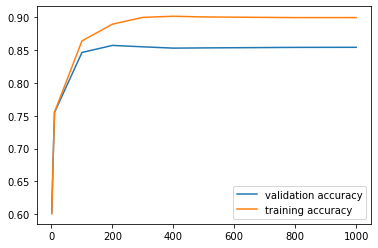

In [49]:
plt.plot(max_iter, results2[:,0], label = 'validation accuracy')
plt.plot(max_iter, results2[:,1], label = 'training accuracy')
plt.legend()
plt.show()

In [40]:
model2 = make_pipeline(prepro2, LogisticRegression(max_iter=700,penalty='none',multi_class='auto'))
begin=time.time()
model2.fit(X_train2, y_train2)
print(f'run time is {time.time()-begin}')
predictVal = model2.score(X_val2,y_val2)
predictTrain = model2.score(X_train2,y_train2)
print('The accuracy of the model in training set: ' + str(predictTrain*100)+ ' %')
print('The accuracy of the model in validation set: ' + str(predictVal*100)+ ' %')

/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


run time is 220.3142387866974
The accuracy of the model in training set: 93.81515338501333 %
The accuracy of the model in validation set: 82.04776148678468 %


In [51]:
#Simple hypertune
solvers = ['newton-cg', 'lbfgs', 'liblinear','sag', 'saga']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1,0.01]
#running all specification and comparing their validation accuracy. Note that if liblinear is not worth running with l1,omitted then
results3 = np.zeros((25,2))
i = 0
for sol in solvers:
    for c in c_values:
        for pen in penalty:
            begin = time.time()
            logic = LogisticRegression(solver = sol, penalty = pen, C=c,max_iter=500,multi_class='auto')
            model = make_pipeline(prepro2, logic)
            model.fit(X_train2, y_train2)
            results3[i,0] = model.score(X_val2,y_val2)
            results3[i,1] = model.score(X_train2,y_train2)
            i+=1
            end = time.time()
            print(f'index for sovler {sol},c value {c} and pennalty {pen} is {i}, run time {end-begin}')
        

index for sovler newton-cg,c value 100 and pennalty l2 is 1, run time 1131.1430768966675
index for sovler newton-cg,c value 10 and pennalty l2 is 2, run time 557.4170451164246
index for sovler newton-cg,c value 1.0 and pennalty l2 is 3, run time 271.4390609264374
index for sovler newton-cg,c value 0.1 and pennalty l2 is 4, run time 106.02876377105713
index for sovler newton-cg,c value 0.01 and pennalty l2 is 5, run time 54.94813418388367


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


index for sovler lbfgs,c value 100 and pennalty l2 is 6, run time 129.98116612434387


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


index for sovler lbfgs,c value 10 and pennalty l2 is 7, run time 130.2090470790863


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


index for sovler lbfgs,c value 1.0 and pennalty l2 is 8, run time 135.50631380081177
index for sovler lbfgs,c value 0.1 and pennalty l2 is 9, run time 125.3658459186554
index for sovler lbfgs,c value 0.01 and pennalty l2 is 10, run time 47.604711055755615


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


index for sovler liblinear,c value 100 and pennalty l2 is 11, run time 295.23400378227234


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


index for sovler liblinear,c value 10 and pennalty l2 is 12, run time 165.40353202819824
index for sovler liblinear,c value 1.0 and pennalty l2 is 13, run time 55.543684005737305
index for sovler liblinear,c value 0.1 and pennalty l2 is 14, run time 35.43060302734375
index for sovler liblinear,c value 0.01 and pennalty l2 is 15, run time 22.93198585510254


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


index for sovler sag,c value 100 and pennalty l2 is 16, run time 162.51967477798462


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


index for sovler sag,c value 10 and pennalty l2 is 17, run time 159.10584807395935


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


index for sovler sag,c value 1.0 and pennalty l2 is 18, run time 156.6833300590515


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


index for sovler sag,c value 0.1 and pennalty l2 is 19, run time 159.38984489440918


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


index for sovler sag,c value 0.01 and pennalty l2 is 20, run time 152.39189291000366


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


index for sovler saga,c value 100 and pennalty l2 is 21, run time 161.31846380233765


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


index for sovler saga,c value 10 and pennalty l2 is 22, run time 166.19987893104553


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


index for sovler saga,c value 1.0 and pennalty l2 is 23, run time 169.4483802318573


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


index for sovler saga,c value 0.1 and pennalty l2 is 24, run time 178.5334038734436


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


index for sovler saga,c value 0.01 and pennalty l2 is 25, run time 195.93982696533203


In [52]:
print(np.concatenate((np.arange(1,26).reshape(25,1), results3),axis=1))

[[ 1.          0.83177234  0.95143659]
 [ 2.          0.84378627  0.93894431]
 [ 3.          0.85403488  0.89935475]
 [ 4.          0.83504144  0.84569553]
 [ 5.          0.79615554  0.79975154]
 [ 6.          0.83986335  0.9380412 ]
 [ 7.          0.84452181  0.933636  ]
 [ 8.          0.85315223  0.90024968]
 [ 9.          0.83500874  0.84565876]
 [10.          0.7961392   0.7997638 ]
 [11.          0.81170009  0.93167859]
 [12.          0.82907534  0.91637891]
 [13.          0.8400595   0.87272742]
 [14.          0.82265156  0.8293579 ]
 [15.          0.78227823  0.78510978]
 [16.          0.80025826  0.80342118]
 [17.          0.80025826  0.80340075]
 [18.          0.80012749  0.80324137]
 [19.          0.7991958   0.8022075 ]
 [20.          0.78888181  0.79152551]
 [21.          0.78773762  0.78988276]
 [22.          0.78772128  0.78986641]
 [23.          0.7876232   0.78982964]
 [24.          0.78710015  0.78920032]
 [25.          0.78010428  0.78219206]]


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


index for c value 10.0 is 1, run time 55.60769319534302


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


index for c value 8.0 is 2, run time 53.40927481651306


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


index for c value 5.0 is 3, run time 52.603445053100586


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


index for c value 2.0 is 4, run time 51.83568000793457


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


index for c value 1.0 is 5, run time 52.84406280517578


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


index for c value 0.8 is 6, run time 52.265661001205444


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


index for c value 0.5 is 7, run time 53.365646839141846


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


index for c value 0.2 is 8, run time 53.480067014694214


/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


index for c value 0.1 is 9, run time 52.15036702156067


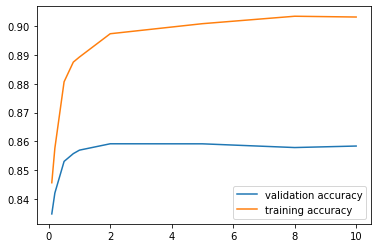

In [18]:
#Simple hypertune
c_values = [10.0, 8.0, 5.0, 2.0, 1.0,0.8,0.5,0.2, 0.1]
#running all specification and comparing their validation accuracy. Note that if liblinear is not worth running with l1,omitted then
results5 = np.zeros((len(c_values),2))
i = 0

for c in c_values:
    begin = time.time()
    logic = LogisticRegression(C=c,max_iter=200,multi_class = 'auto') #default lbfgs with l2 penalty
    model = make_pipeline(prepro2, logic)
    model.fit(X_train2, y_train2)
    results5[i,0] = model.score(X_val2,y_val2)
    results5[i,1] = model.score(X_train2,y_train2)
    i+=1
    end = time.time()
    print(f'index for c value {c} is {i}, run time {end-begin}')
    


In [55]:
print(np.concatenate((np.array(c_values).reshape(len(c_values),1), results5),axis=1))

[[10.          0.85838278  0.90312246]
 [ 8.          0.85785972  0.90339216]
 [ 5.          0.85915102  0.90081361]
 [ 2.          0.85916736  0.89732378]
 [ 1.          0.85696072  0.88925304]
 [ 0.8         0.85575116  0.88748769]
 [ 0.5         0.85305415  0.88066331]
 [ 0.2         0.84210268  0.85764841]
 [ 0.1         0.83484529  0.84565876]]


In [41]:
#pick best validation accuracy
model2 = make_pipeline(prepro2, LogisticRegression(max_iter=200,multi_class='auto',C=2.0))

model2.fit(X_train2, y_train2)

predictVal = model2.score(X_val2,y_val2)
predictTrain = model2.score(X_train2,y_train2)
print('The accuracy of the model in training set: ' + str(predictTrain*100)+ ' %')
print('The accuracy of the model in validation set: ' + str(predictVal*100)+ ' %')

/Users/Tinaisha/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The accuracy of the model in training set: 89.73237819305221 %
The accuracy of the model in validation set: 85.91673613494827 %


In [42]:
print(model2[1].coef_)
print(model2[1].intercept_)

[[-5.44844137e-01 -2.24325115e-01 -2.53240784e-01 ... -4.63675158e+00
  -4.66411150e+00 -1.84580218e-01]
 [-1.11314074e-03 -2.26956060e-01 -5.16659679e-04 ...  1.72175788e+01
   1.73582536e+01  1.44669249e+00]
 [ 5.83079763e-01  2.76230116e-01  2.62393165e-01 ... -4.65280012e+00
  -4.70942241e+00 -7.53423499e-01]
 [-1.84720312e-02  4.61948064e-01 -1.44914198e-03 ... -3.61917528e+00
  -3.61527922e+00  3.47844797e-01]
 [-1.86504549e-02 -2.86897005e-01 -7.18657950e-03 ... -4.30885186e+00
  -4.36944043e+00 -8.56533565e-01]]
[ 17.00455938 -53.2587089   15.63216986  10.00753711  10.61444255]


#### Try convolution network

In [12]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras.optimizers import SGD
from keras.initializers import random_uniform
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils.np_utils import to_categorical

from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import cross_val_score

SEED = 42
np.random.seed(SEED)

In [13]:
X_trainConv1 = prepro1.fit_transform(X_train1).toarray()
X_valConv1 = prepro1.fit_transform(X_val1).toarray()
# X_trainConv2 = prepro2.fit_transform(X_train2).toarray()
# X_valConv2 = prepro2.fit_transform(X_val2).toarray()

print(X_trainConv1.shape)
print(X_valConv1.shape)
# print(X_trainConv2.shape)
# print(X_valConv2.shape)

X_trainConv1 = np.reshape(X_trainConv1, (X_trainConv1.shape[0],X_trainConv1.shape[1],1))
X_valConv1 = np.reshape(X_valConv1, (X_valConv1.shape[0],X_valConv1.shape[1],1))
# X_trainConv2 = np.reshape(X_trainConv2, X_trainConv2.shape + (1,))
# X_valConv2 = np.reshape(X_valConv2, X_valConv2.shape + (1,))

print(X_trainConv1.shape)
print(X_valConv1.shape)
# print(X_trainConv2.shape)
# print(X_valConv2.shape)

(244711, 25)
(61179, 25)
(244711, 25, 1)
(61179, 25, 1)


In [37]:
print(y_train1.shape)
print(type(y_train1))
print(y_train1.value_counts())

(244711,)
<class 'pandas.core.series.Series'>
failed        142355
successful     96447
undefined       2565
live            2015
suspended       1329
Name: state, dtype: int64


In [14]:
dum1 = OneHotEncoder(categories=[['successful','failed','undefined','live','suspended']]).fit(y_train1.values.reshape(-1,1))
y_trainConv1 = dum1.transform(y_train1.values.reshape(-1,1)).toarray()
print(y_trainConv1.shape)
dum1 = OneHotEncoder(categories=[['successful','failed','undefined','live','suspended']]).fit(y_val1.values.reshape(-1,1))
y_valConv1 = dum1.transform(y_val1.values.reshape(-1,1)).toarray()
print(y_valConv1.shape)



(244711, 5)
(61179, 5)


Very suspicious! if we do drop 1 classes, it give suspiciously high accuracy for both training and validation (about 97%!). Furthermore, adam optimizer behaving very strangely (abnormally high loss and extremely low training accuracy but just as high validation accuracy)

For this multi-class problem, I will be using no dropped since it could be the case that dropping 1 class can be considered "losing information" since there are not really any restriction on the exclusive category. When we did this, sgd not working again and only Adam is working

In [146]:
#SGD not working in this case
verbose = 1
epochs = 5
batch_size = 512
dropRate = 0.2
nOut = 5
X_train, y_train = X_trainConv1, y_trainConv1

model3 = Sequential()
model3.add(Conv1D(filters=32, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu', input_shape=(25,1)))
model3.add(Conv1D(filters=16, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu'))
model3.add(Dropout(dropRate))
model3.add(Conv1D(filters=32, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu'))
model3.add(MaxPooling1D(pool_size=4))
model3.add(Flatten())
model3.add(Dense(units=16, kernel_initializer='normal', activation='relu'))
model3.add(Dropout(dropRate))
model3.add(Dense(units=nOut, activation='softmax'))
model3.summary()

optimizer = SGD(learning_rate=0.0001) #,momentum=0.0)
model3.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # fit network
history = model3.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_data=(X_valConv1, y_valConv1))
model3.evaluate(X_valConv1, y_valConv1)



Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_27 (Conv1D)          (None, 25, 32)            128       
                                                                 
 conv1d_28 (Conv1D)          (None, 25, 16)            1552      
                                                                 
 dropout_17 (Dropout)        (None, 25, 16)            0         
                                                                 
 conv1d_29 (Conv1D)          (None, 25, 64)            3136      
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 6, 64)            0         
 g1D)                                                            
                                                                 
 flatten_9 (Flatten)         (None, 384)               0         
                                                      

[1.4604952335357666, 0.5817192196846008]

In [139]:
_, accuracy = model3.evaluate(X_valConv1, y_valConv1, batch_size=batch_size, verbose=0)
print(accuracy)

0.5817192196846008


In [16]:
verbose = 1
epochs = 20
batch_size = 514
dropRate = 0.2
nOut = 5
X_train, y_train = X_trainConv1, y_trainConv1
hidden_initializer = random_uniform(seed=SEED)

model3 = Sequential()
model3.add(Conv1D(filters=32, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu', input_shape=(25,1)))
model3.add(Conv1D(filters=16, kernel_size=1, padding='same', kernel_initializer='normal', activation='relu'))
model3.add(MaxPooling1D(pool_size=2))
model3.add(Conv1D(filters=32, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu'))
model3.add(MaxPooling1D(pool_size=2))
model3.add(Dropout(dropRate))
model3.add(Flatten())
model3.add(Dense(units=16, kernel_initializer='normal', activation='relu'))
model3.add(Dropout(dropRate))
model3.add(Dense(units=nOut, activation='softmax'))
model3.summary()

# optimizer = SGD(lr=0.0001) #,momentum=0.0)
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # fit network
history = model3.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_data=(X_valConv1, y_valConv1))
model3.evaluate(X_valConv1, y_valConv1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 25, 32)            128       
                                                                 
 conv1d_1 (Conv1D)           (None, 25, 16)            528       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 12, 16)           0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 12, 32)            1568      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 6, 32)            0         
 1D)                                                             
                                                                 
 dropout (Dropout)           (None, 6, 32)             0

[0.5145541429519653, 0.8636460304260254]

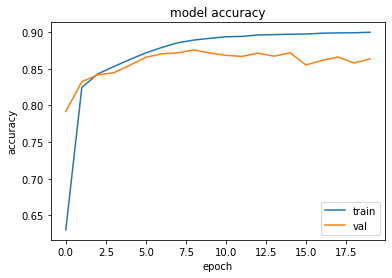

In [17]:
plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'],label = 'val')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()

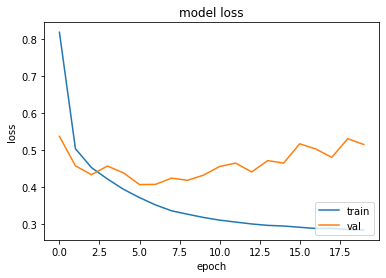

In [18]:
plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'val')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()

picking 5 epochs should be adequate. We will be using this to hypertune paramters.

Also, try this with different architectures:

In [16]:
print(X_trainConv1.shape)
print(X_valConv1.shape)
X_Conv1 = np.concatenate((X_trainConv1,X_valConv1), axis = 0)
print(X_Conv1.shape)
y_Conv1 = np.concatenate((y_trainConv1,y_valConv1), axis = 0)
print(y_Conv1.shape)

verbose = 0
epochs = 5
batch_size = 514

kfold = KFold(n_splits=10, shuffle=True, random_state=123)

(244711, 25, 1)
(61179, 25, 1)
(305890, 25, 1)
(305890, 5)


In [20]:
def create_model(dropRate = 0.2,nOut = 5):   
    model3 = Sequential()
    model3.add(Conv1D(filters=32, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu', input_shape=(25,1)))
    model3.add(Conv1D(filters=16, kernel_size=1, padding='same', kernel_initializer='normal', activation='relu'))
    model3.add(MaxPooling1D(pool_size=2))
    model3.add(Conv1D(filters=32, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu'))
    model3.add(MaxPooling1D(pool_size=2))
#     model3.add(Dropout(dropRate))
    model3.add(Flatten())
    model3.add(Dense(units=16, kernel_initializer='normal', activation='relu'))
#     model3.add(Dropout(dropRate))
    model3.add(Dense(units=nOut, activation='softmax'))
#     model3.summary()

        # optimizer = SGD(lr=0.0001) #,momentum=0.0)
    model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print("start")
    return model3

estimators = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=verbose)
results = cross_val_score(estimators, X_Conv1, y_Conv1, cv=kfold,verbose=1,)
print("without Drop: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))



<ipython-input-20-b364308d806b>:20: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  estimators = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=verbose)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


start
start
start
start
start
start
start
start
start
start
without Drop: 87.69% (0.87%)


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  7.4min finished


In [21]:
def create_model(dropRate = 0.2,nOut = 5):   
    model3 = Sequential()
    model3.add(Conv1D(filters=32, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu', input_shape=(25,1)))
    model3.add(Conv1D(filters=16, kernel_size=1, padding='same', kernel_initializer='normal', activation='relu'))
    model3.add(MaxPooling1D(pool_size=2))
    model3.add(Conv1D(filters=32, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu'))
    model3.add(MaxPooling1D(pool_size=2))
    model3.add(Dropout(dropRate))
    model3.add(Flatten())
    model3.add(Dense(units=16, kernel_initializer='normal', activation='relu'))
    model3.add(Dropout(dropRate))
    model3.add(Dense(units=nOut, activation='softmax'))
#     model3.summary()

        # optimizer = SGD(lr=0.0001) #,momentum=0.0)
    model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print("start")
    return model3

estimators = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=verbose)
resultsWithDrop = cross_val_score(estimators, X_Conv1, y_Conv1, cv=kfold,verbose=1)
print("with Drop: %.2f%% (%.2f%%)" % (resultsWithDrop.mean()*100, resultsWithDrop.std()*100))
print("with no Drop: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))



<ipython-input-21-4167629f00ae>:20: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  estimators = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=verbose)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


start
start
start
start
start
start
start
start
start
start
with Drop: 87.61% (0.79%)
with no Drop: 87.69% (0.87%)


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  7.1min finished


In [21]:
def create_model(dropRate = 0.2,nOut = 5):   
    model3 = Sequential()
    model3.add(Conv1D(filters=64, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu', input_shape=(25,1)))
    model3.add(Conv1D(filters=32, kernel_size=1, padding='same', kernel_initializer='normal', activation='relu'))
    model3.add(MaxPooling1D(pool_size=2))
    model3.add(Conv1D(filters=64, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu'))
    model3.add(MaxPooling1D(pool_size=2))
    model3.add(Dropout(dropRate))
    model3.add(Flatten())
    model3.add(Dense(units=32, kernel_initializer='normal', activation='relu'))
    model3.add(Dropout(dropRate))
    model3.add(Dense(units=nOut, activation='softmax'))
#     model3.summary()

        # optimizer = SGD(lr=0.0001) #,momentum=0.0)
    model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print("start")
    return model3

estimators = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=verbose)
resultsMoreFilter = cross_val_score(estimators, X_Conv1, y_Conv1, cv=kfold,verbose=1)
print("with Drop: %.2f%% (%.2f%%)" % (resultsMoreFilter.mean()*100, resultsMoreFilter.std()*100))



<ipython-input-21-9d7a4a904733>:20: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  estimators = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=verbose)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


start
start
start
start
start
start
start
start
start
start
with Drop: 89.24% (0.21%)


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 10.8min finished


In [23]:
def create_model(dropRate = 0.2,nOut = 5):   
    model3 = Sequential()
    model3.add(Conv1D(filters=16, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu', input_shape=(25,1)))
    model3.add(Conv1D(filters=8, kernel_size=1, padding='same', kernel_initializer='normal', activation='relu'))
    model3.add(MaxPooling1D(pool_size=2))
    model3.add(Conv1D(filters=16, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu'))
    model3.add(MaxPooling1D(pool_size=2))
    model3.add(Dropout(dropRate))
    model3.add(Flatten())
    model3.add(Dense(units=8, kernel_initializer='normal', activation='relu'))
    model3.add(Dropout(dropRate))
    model3.add(Dense(units=nOut, activation='softmax'))
#     model3.summary()

        # optimizer = SGD(lr=0.0001) #,momentum=0.0)
    model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print("start")
    return model3

estimators = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=verbose)
resultsLessFilter = cross_val_score(estimators, X_Conv1, y_Conv1, cv=kfold,verbose=1)
print("with Drop: %.2f%% (%.2f%%)" % (resultsLessFilter.mean()*100, resultsLessFilter.std()*100))




<ipython-input-23-f013c347fa42>:20: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  estimators = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=verbose)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


start
start
start
start
start
start
start
start
start
start
with Drop: 84.42% (1.66%)


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  3.9min finished


In [24]:
def create_model(dropRate = 0.2,nOut = 5):   
    model3 = Sequential()
    model3.add(Conv1D(filters=32, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu', input_shape=(25,1)))
    model3.add(Conv1D(filters=16, kernel_size=1, padding='same', kernel_initializer='normal', activation='relu'))
    model3.add(MaxPooling1D(pool_size=2))
    model3.add(Conv1D(filters=32, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu'))
    model3.add(MaxPooling1D(pool_size=2))
    model3.add(Dropout(dropRate))
    model3.add(Flatten())
    model3.add(Dense(units=16, kernel_initializer='normal', activation='relu'))
#     model3.add(Dropout(dropRate))
    model3.add(Dense(units=nOut, activation='softmax'))
#     model3.summary()

        # optimizer = SGD(lr=0.0001) #,momentum=0.0)
    model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print("start")
    return model3

estimators = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=verbose)
resultsWith1Drop = cross_val_score(estimators, X_Conv1, y_Conv1, cv=kfold,verbose=1)
print("with Drop: %.2f%% (%.2f%%)" % (resultsWith1Drop.mean()*100, resultsWith1Drop.std()*100))
print("with no Drop: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))




<ipython-input-24-428f3bbdb8a6>:20: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  estimators = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=verbose)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


start
start
start
start
start
start
start
start
start
start
with Drop: 87.39% (1.50%)
with no Drop: 87.69% (0.87%)


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  6.3min finished


In [25]:
def create_model(dropRate = 0.2,nOut = 5):   
    model3 = Sequential()
    model3.add(Conv1D(filters=32, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu', input_shape=(25,1)))
    model3.add(Conv1D(filters=16, kernel_size=1, padding='same', kernel_initializer='normal', activation='relu'))
    model3.add(MaxPooling1D(pool_size=2))
    model3.add(Conv1D(filters=32, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu'))
    model3.add(MaxPooling1D(pool_size=2))
#     model3.add(Dropout(dropRate))
    model3.add(Flatten())
    model3.add(Dense(units=16, kernel_initializer='normal', activation='relu'))
    model3.add(Dropout(dropRate))
    model3.add(Dense(units=nOut, activation='softmax'))
#     model3.summary()

        # optimizer = SGD(lr=0.0001) #,momentum=0.0)
    model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print("start")
    return model3

estimators = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=verbose)
resultsWith1Dropbix = cross_val_score(estimators, X_Conv1, y_Conv1, cv=kfold,verbose=1)
print("with Drop: %.2f%% (%.2f%%)" % (resultsWith1Dropbix.mean()*100, resultsWith1Dropbix.std()*100))
print("with no Drop: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))





<ipython-input-25-a0a12236cdc3>:20: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  estimators = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=verbose)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


start
start
start
start
start
start
start
start
start
start
with Drop: 87.77% (0.82%)
with no Drop: 87.69% (0.87%)


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  6.4min finished


In [26]:
def create_model(dropRate = 0.2,nOut = 5):   
    model3 = Sequential()
    model3.add(Conv1D(filters=32, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu', input_shape=(25,1)))
    model3.add(Conv1D(filters=16, kernel_size=1, padding='same', kernel_initializer='normal', activation='relu'))
    model3.add(MaxPooling1D(pool_size=2))
    model3.add(Conv1D(filters=32, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu'))
    model3.add(MaxPooling1D(pool_size=2))
    model3.add(Dropout(dropRate))
    model3.add(Flatten())
    model3.add(Dense(units=32, kernel_initializer='normal', activation='relu'))
    model3.add(Dense(units=16, kernel_initializer='normal', activation='relu'))
    model3.add(Dropout(dropRate))
    model3.add(Dense(units=nOut, activation='softmax'))
#     model3.summary()

        # optimizer = SGD(lr=0.0001) #,momentum=0.0)
    model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print("start")
    return model3

estimators = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=verbose)
resultsAlter = cross_val_score(estimators, X_Conv1, y_Conv1, cv=kfold,verbose=1)
print("with Drop: %.2f%% (%.2f%%)" % (resultsAlter.mean()*100, resultsAlter.std()*100))
print("with no Drop: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))


<ipython-input-26-c188641fa375>:21: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  estimators = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=verbose)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


start
start
start
start
start
start
start
start
start
start
with Drop: 88.46% (0.59%)
with no Drop: 87.69% (0.87%)


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  7.3min finished


In [20]:
def create_model(dropRate = 0.2,nOut = 5):   
    model3 = Sequential()
    model3.add(Conv1D(filters=64, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu', input_shape=(25,1)))
    model3.add(Conv1D(filters=32, kernel_size=1, padding='same', kernel_initializer='normal', activation='relu'))
    model3.add(MaxPooling1D(pool_size=2))
    model3.add(Conv1D(filters=64, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu'))
    model3.add(MaxPooling1D(pool_size=2))
#     model3.add(Dropout(dropRate))
    model3.add(Flatten())
    model3.add(Dense(units=32, kernel_initializer='normal', activation='relu'))
#     model3.add(Dropout(dropRate))
    model3.add(Dense(units=nOut, activation='softmax'))
#     model3.summary()

        # optimizer = SGD(lr=0.0001) #,momentum=0.0)
    model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print("start")
    return model3

estimators = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=verbose)
resultsNorm = cross_val_score(estimators, X_Conv1, y_Conv1, cv=kfold,verbose=1)
print("Hidden: %.2f%% (%.2f%%)" % (resultsNorm.mean()*100, resultsNorm.std()*100))




<ipython-input-20-97bf7f57a670>:20: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  estimators = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=verbose)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


start
start
start
start
start
start
start
start
start
start
Hidden: 89.17% (0.29%)


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 10.8min finished


save files

In [67]:
print(type(results))
print(results.shape)

<class 'numpy.ndarray'>
(10,)


In [31]:
BigResults = np.zeros((8,results.shape[0]))
BigResults[0,:] = results
BigResults[1,:] = resultsWithDrop
BigResults[2,:] = resultsMoreFilter
BigResults[3,:] = resultsLessFilter
BigResults[4,:] = resultsWith1Drop
BigResults[5,:] = resultsWith1Dropbix
BigResults[6,:] = resultsAlter
BigResults[7,:] = resultsNorm
np.save("BigResults2.npy", BigResults)

In [32]:
BigResults = np.load("BigResults2.npy")
for i in range(8):
    print(f'mean (std) is {BigResults[i,:].mean()*100} ({ BigResults[i,:].std()*100})')

mean (std) is 87.68805861473083 (0.8685291942095293)
mean (std) is 87.60992407798767 (0.788596968690579)
mean (std) is 89.14511799812317 (0.3416849868841315)
mean (std) is 84.42152440547943 (1.655024056517719)
mean (std) is 87.38566100597382 (1.4974178602129748)
mean (std) is 87.77011334896088 (0.8155131941536661)
mean (std) is 88.46186459064484 (0.589427890868307)
mean (std) is 89.17225182056427 (0.24552825792458258)


regarding the dropRate

In [33]:
def create_model(dropRate = 0.5,nOut = 5):   
    model3 = Sequential()
    model3.add(Conv1D(filters=64, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu', input_shape=(25,1)))
    model3.add(Conv1D(filters=32, kernel_size=1, padding='same', kernel_initializer='normal', activation='relu'))
    model3.add(MaxPooling1D(pool_size=2))
    model3.add(Conv1D(filters=64, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu'))
    model3.add(MaxPooling1D(pool_size=2))
    model3.add(Dropout(dropRate))
    model3.add(Flatten())
    model3.add(Dense(units=32, kernel_initializer='normal', activation='relu'))
    model3.add(Dropout(dropRate))
    model3.add(Dense(units=nOut, activation='softmax'))

    model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print("start")
    return model3
    
estimators = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=verbose)
resultsDrop05 = cross_val_score(estimators, X_Conv1, y_Conv1, cv=kfold,verbose=1)
print("Hidden: %.2f%% (%.2f%%)" % (resultsDrop05.mean()*100, resultsDrop05.std()*100))


<ipython-input-33-8e0bdece692a>:18: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  estimators = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=verbose)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


start
start
start
start
start
start
start
start
start
start
Hidden: 88.75% (0.42%)


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 12.0min finished


In [23]:
def create_model(dropRate = 0.1,nOut = 5):   
    model3 = Sequential()
    model3.add(Conv1D(filters=64, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu', input_shape=(25,1)))
    model3.add(Conv1D(filters=32, kernel_size=1, padding='same', kernel_initializer='normal', activation='relu'))
    model3.add(MaxPooling1D(pool_size=2))
    model3.add(Conv1D(filters=64, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu'))
    model3.add(MaxPooling1D(pool_size=2))
    model3.add(Dropout(dropRate))
    model3.add(Flatten())
    model3.add(Dense(units=32, kernel_initializer='normal', activation='relu'))
    model3.add(Dropout(dropRate))
    model3.add(Dense(units=nOut, activation='softmax'))

    model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print("start")
    return model3
    
estimators = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=verbose)
resultsDrop01 = cross_val_score(estimators, X_Conv1, y_Conv1, cv=kfold,verbose=1)
print("Hidden: %.2f%% (%.2f%%)" % (resultsDrop01.mean()*100, resultsDrop01.std()*100))




<ipython-input-23-f9157f00f375>:18: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  estimators = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=verbose)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


start
start
start
start
start
start
start
start
start
start
Hidden: 89.46% (0.26%)


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 11.7min finished


Model: "sequential_70"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_210 (Conv1D)         (None, 25, 64)            256       
                                                                 
 conv1d_211 (Conv1D)         (None, 25, 32)            2080      
                                                                 
 max_pooling1d_140 (MaxPooli  (None, 12, 32)           0         
 ng1D)                                                           
                                                                 
 conv1d_212 (Conv1D)         (None, 12, 64)            6208      
                                                                 
 max_pooling1d_141 (MaxPooli  (None, 6, 64)            0         
 ng1D)                                                           
                                                                 
 dropout_80 (Dropout)        (None, 6, 64)           

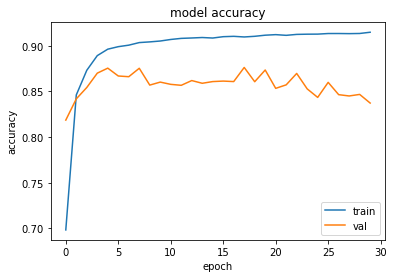

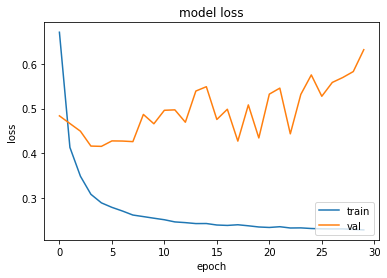

In [24]:
# Final chosen model:
np.random.seed(123)
verbose = 1
epochs = 30
batch_size = 514
dropRate = 0.1
nOut = 5
X_train, y_train = X_trainConv1, y_trainConv1

model3 = Sequential()
model3.add(Conv1D(filters=64, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu', input_shape=(25,1)))
model3.add(Conv1D(filters=32, kernel_size=1, padding='same', kernel_initializer='normal', activation='relu'))
model3.add(MaxPooling1D(pool_size=2))
model3.add(Conv1D(filters=64, kernel_size=3, padding='same', kernel_initializer='normal', activation='relu'))
model3.add(MaxPooling1D(pool_size=2))
model3.add(Dropout(dropRate))
model3.add(Flatten())
model3.add(Dense(units=32, kernel_initializer='normal', activation='relu'))
model3.add(Dropout(dropRate))
model3.add(Dense(units=nOut, activation='softmax'))
model3.summary()

model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # fit network
history = model3.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_data=(X_valConv1, y_valConv1))
model3.evaluate(X_valConv1, y_valConv1)

plt.plot(history.history['accuracy'], label = 'train')
plt.plot(history.history['val_accuracy'],label = 'val')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label = 'train')
plt.plot(history.history['val_loss'], label = 'val')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()

In [25]:
print(max(history.history['val_accuracy']))
print(np.argmax(history.history['val_accuracy'])+1)

0.8763137459754944
18


In [26]:
#pick model 3
model3.fit(X_train, y_train, epochs=18, batch_size=batch_size, verbose=0, validation_data=(X_valConv1, y_valConv1))


#### Try decision tree

In [43]:
model4 = make_pipeline(prepro1, DecisionTreeClassifier(max_depth = 5))

model4.fit(X_train1, y_train1)

predictVal = model4.score(X_val1,y_val1)
predictTrain = model4.score(X_train1,y_train1)
print('The accuracy of the model in training set: ' + str(predictTrain*100)+ ' %')
print('The accuracy of the model in validation set: ' + str(predictVal*100)+ ' %')

The accuracy of the model in training set: 90.37885505759856 %
The accuracy of the model in validation set: 90.49183543372726 %


In [54]:
max_depth = [1,3,5,7,8,9,10,11,12,15,20]
resultsDT = np.zeros((len(max_depth),2))

for i in range(len(max_depth)):

    model4 = make_pipeline(prepro1, DecisionTreeClassifier(max_depth = max_depth[i]))
    model4.fit(X_train1, y_train1)
    
    resultsDT[i,0] = model4.score(X_val1,y_val1)
    resultsDT[i,1] = model4.score(X_train1,y_train1)
    print(f'The accuracy of the model in validation set with depth {max_depth[i]}: {resultsDT[i,0]*100}%')
    print(f'The accuracy of the model in training set with depth {max_depth[i]}: {resultsDT[i,1]*100}%')
    

The accuracy of the model in validation set with depth 1: 82.17689076317038%
The accuracy of the model in training set with depth 1: 82.09684076318597%
The accuracy of the model in validation set with depth 3: 88.82296212752742%
The accuracy of the model in training set with depth 3: 88.79698910142984%
The accuracy of the model in validation set with depth 5: 90.49183543372726%
The accuracy of the model in training set with depth 5: 90.37885505759856%
The accuracy of the model in validation set with depth 7: 91.14565455466746%
The accuracy of the model in training set with depth 7: 91.20309262763014%
The accuracy of the model in validation set with depth 8: 91.47746775854459%
The accuracy of the model in training set with depth 8: 91.58967108139807%
The accuracy of the model in validation set with depth 9: 91.8141846058288%
The accuracy of the model in training set with depth 9: 92.02814748826167%
The accuracy of the model in validation set with depth 10: 91.84197191846876%
The accurac

In [55]:
print(resultsDT)

[[0.82176891 0.82096841]
 [0.88822962 0.88796989]
 [0.90491835 0.90378855]
 [0.91145655 0.91203093]
 [0.91477468 0.91589671]
 [0.91814185 0.92028147]
 [0.91841972 0.92316242]
 [0.91861586 0.92632125]
 [0.91773321 0.92986012]
 [0.91096618 0.94408506]
 [0.89529087 0.97135396]]


In [46]:
max_depth = [1,3,5,7,8,9,10,11,12,15,20]
resultsDT2 = np.zeros((len(max_depth),2))

for i in range(len(max_depth)):

    model4 = make_pipeline(prepro1, DecisionTreeClassifier(max_depth = max_depth[i], criterion='entropy'))
    model4.fit(X_train1, y_train1)
    
    resultsDT2[i,0] = model4.score(X_val1,y_val1)
    resultsDT2[i,1] = model4.score(X_train1,y_train1)
    print(f'The accuracy of the model in validation set with depth {max_depth[i]}: {resultsDT2[i,0]*100}%')
    print(f'The accuracy of the model in training set with depth {max_depth[i]}: {resultsDT2[i,1]*100}%')


The accuracy of the model in validation set with depth 1: 81.20596936857419%
The accuracy of the model in training set with depth 1: 81.11486610736746%
The accuracy of the model in validation set with depth 3: 87.86838621095474%
The accuracy of the model in training set with depth 3: 87.91717577060287%
The accuracy of the model in validation set with depth 5: 89.72032887101783%
The accuracy of the model in training set with depth 5: 89.87622133864028%
The accuracy of the model in validation set with depth 7: 91.18324915412151%
The accuracy of the model in training set with depth 7: 91.26234619612522%
The accuracy of the model in validation set with depth 8: 91.56736788767388%
The accuracy of the model in training set with depth 8: 91.6975534405891%
The accuracy of the model in validation set with depth 9: 91.68505532944312%
The accuracy of the model in training set with depth 9: 91.85038678277641%
The accuracy of the model in validation set with depth 10: 91.94331388221448%
The accurac

In [47]:
print(resultsDT2)

[[0.81205969 0.81114866]
 [0.87868386 0.87917176]
 [0.89720329 0.89876221]
 [0.91183249 0.91262346]
 [0.91567368 0.91697553]
 [0.91685055 0.91850387]
 [0.91943314 0.92078002]
 [0.9186649  0.92324415]
 [0.9186649  0.92627221]
 [0.91202864 0.93875633]
 [0.89818402 0.96503631]]


In [48]:
max_depth = [1,3,5,7,8,9,10,11,12,15,20]
resultsDT3 = np.zeros((len(max_depth),2))

for i in range(len(max_depth)):

    model4 = make_pipeline(prepro1, DecisionTreeClassifier(max_depth = max_depth[i], min_samples_leaf=1000))
    model4.fit(X_train1, y_train1)
    
    resultsDT3[i,0] = model4.score(X_val1,y_val1)
    resultsDT3[i,1] = model4.score(X_train1,y_train1)
    print(f'The accuracy of the model in validation set with depth {max_depth[i]}: {resultsDT3[i,0]*100}%')
    print(f'The accuracy of the model in training set with depth {max_depth[i]}: {resultsDT3[i,1]*100}%')

The accuracy of the model in validation set with depth 1: 82.17689076317038%
The accuracy of the model in training set with depth 1: 82.09684076318597%
The accuracy of the model in validation set with depth 3: 88.82296212752742%
The accuracy of the model in training set with depth 3: 88.79698910142984%
The accuracy of the model in validation set with depth 5: 90.30386243645695%
The accuracy of the model in training set with depth 5: 90.20313757861314%
The accuracy of the model in validation set with depth 7: 90.6225992579153%
The accuracy of the model in training set with depth 7: 90.6289459811778%
The accuracy of the model in validation set with depth 8: 90.84816685463967%
The accuracy of the model in training set with depth 8: 90.81528823796233%
The accuracy of the model in validation set with depth 9: 90.91191421893133%
The accuracy of the model in training set with depth 9: 90.90764207575467%
The accuracy of the model in validation set with depth 10: 90.91191421893133%
The accuracy

In [49]:
print(resultsDT3)

[[0.82176891 0.82096841]
 [0.88822962 0.88796989]
 [0.90303862 0.90203138]
 [0.90622599 0.90628946]
 [0.90848167 0.90815288]
 [0.90911914 0.90907642]
 [0.90911914 0.90907642]
 [0.90911914 0.90907642]
 [0.90911914 0.90907642]
 [0.90911914 0.90907642]
 [0.90911914 0.90907642]]


In [50]:
max_depth = [1,3,5,7,8,9,10,11,12,15,20]
resultsDT4 = np.zeros((len(max_depth),2))

for i in range(len(max_depth)):

    model4 = make_pipeline(prepro1, DecisionTreeClassifier(max_depth = max_depth[i], min_samples_leaf=40))
    model4.fit(X_train1, y_train1)
    
    resultsDT4[i,0] = model4.score(X_val1,y_val1)
    resultsDT4[i,1] = model4.score(X_train1,y_train1)
    print(f'The accuracy of the model in validation set with depth {max_depth[i]}: {resultsDT4[i,0]*100}%')
    print(f'The accuracy of the model in training set with depth {max_depth[i]}: {resultsDT4[i,1]*100}%')

The accuracy of the model in validation set with depth 1: 82.17689076317038%
The accuracy of the model in training set with depth 1: 82.09684076318597%
The accuracy of the model in validation set with depth 3: 88.82296212752742%
The accuracy of the model in training set with depth 3: 88.79698910142984%
The accuracy of the model in validation set with depth 5: 90.49183543372726%
The accuracy of the model in training set with depth 5: 90.37640318579876%
The accuracy of the model in validation set with depth 7: 91.13094362444629%
The accuracy of the model in training set with depth 7: 91.16345403353343%
The accuracy of the model in validation set with depth 8: 91.46929501953285%
The accuracy of the model in training set with depth 8: 91.56964746169972%
The accuracy of the model in validation set with depth 9: 91.71447718988541%
The accuracy of the model in training set with depth 9: 91.94968759066818%
The accuracy of the model in validation set with depth 10: 91.78966638879355%
The accura

In [51]:
print(resultsDT4)

[[0.82176891 0.82096841]
 [0.88822962 0.88796989]
 [0.90491835 0.90376403]
 [0.91130944 0.91163454]
 [0.91469295 0.91569647]
 [0.91714477 0.91949688]
 [0.91789666 0.92109059]
 [0.91832165 0.92221437]
 [0.91817454 0.92274561]
 [0.91735726 0.92348934]
 [0.91719381 0.92369775]]


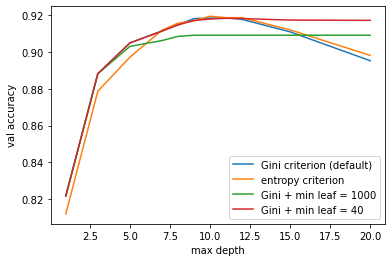

the highest validation accuracy for Gini default is 0.9186158649209696 at depth 11
the highest validation accuracy for entropy is 0.9194331388221448 at depth 10
the highest validation accuracy for Gini min leaf 1000 is 0.9091191421893133 at depth 9
the highest validation accuracy for Gini min leaf 40 is 0.9183216463165466 at depth 11


In [56]:
plt.plot(max_depth, resultsDT[:,0], label='Gini criterion (default)')
plt.plot(max_depth, resultsDT2[:,0], label='entropy criterion')
plt.plot(max_depth, resultsDT3[:,0], label='Gini + min leaf = 1000')
plt.plot(max_depth, resultsDT4[:,0], label='Gini + min leaf = 40')
plt.legend()
plt.xlabel('max depth')
plt.ylabel('val accuracy')
plt.show()
print(f'the highest validation accuracy for Gini default is {np.max(resultsDT[:,0])} at depth {max_depth[np.argmax(resultsDT[:,0])]}')
print(f'the highest validation accuracy for entropy is {np.max(resultsDT2[:,0])} at depth {max_depth[np.argmax(resultsDT2[:,0])]}')
print(f'the highest validation accuracy for Gini min leaf 1000 is {np.max(resultsDT3[:,0])} at depth {max_depth[np.argmax(resultsDT3[:,0])]}')
print(f'the highest validation accuracy for Gini min leaf 40 is {np.max(resultsDT4[:,0])} at depth {max_depth[np.argmax(resultsDT4[:,0])]}')



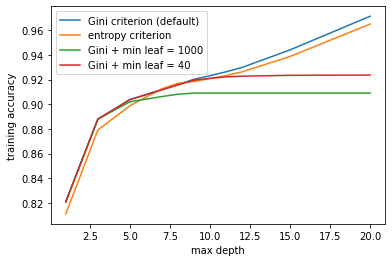

the highest training accuracy for Gini default is 0.9713539644723777 at depth 20
the highest training accuracy for entropy is 0.9650363081349019 at depth 20
the highest training accuracy for Gini min leaf 1000 is 0.9090764207575467 at depth 9
the highest training accuracy for Gini min leaf 40 is 0.9236977495903331 at depth 20


In [57]:
plt.plot(max_depth, resultsDT[:,1], label='Gini criterion (default)')
plt.plot(max_depth, resultsDT2[:,1], label='entropy criterion')
plt.plot(max_depth, resultsDT3[:,1], label='Gini + min leaf = 1000')
plt.plot(max_depth, resultsDT4[:,1], label='Gini + min leaf = 40')
plt.legend()
plt.xlabel('max depth')
plt.ylabel('training accuracy')
plt.show()
print(f'the highest training accuracy for Gini default is {np.max(resultsDT[:,1])} at depth {max_depth[np.argmax(resultsDT[:,1])]}')
print(f'the highest training accuracy for entropy is {np.max(resultsDT2[:,1])} at depth {max_depth[np.argmax(resultsDT2[:,1])]}')
print(f'the highest training accuracy for Gini min leaf 1000 is {np.max(resultsDT3[:,1])} at depth {max_depth[np.argmax(resultsDT3[:,1])]}')
print(f'the highest training accuracy for Gini min leaf 40 is {np.max(resultsDT4[:,1])} at depth {max_depth[np.argmax(resultsDT4[:,1])]}')



In [52]:
from sklearn import tree

In [73]:
model4 = make_pipeline(prepro1, DecisionTreeClassifier(max_depth = 10, criterion='entropy'))
model4.fit(X_train1, y_train1)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(categories=[['Film '
                                                                             '& '
                                                                             'Video',
                                                                             'Music',
                                                                             'Publishing',
                                                                             'Games',
                                                                             'Technology',
                                                                             'Art',
                                                                             'Design',
                                                                             'Food',
                                

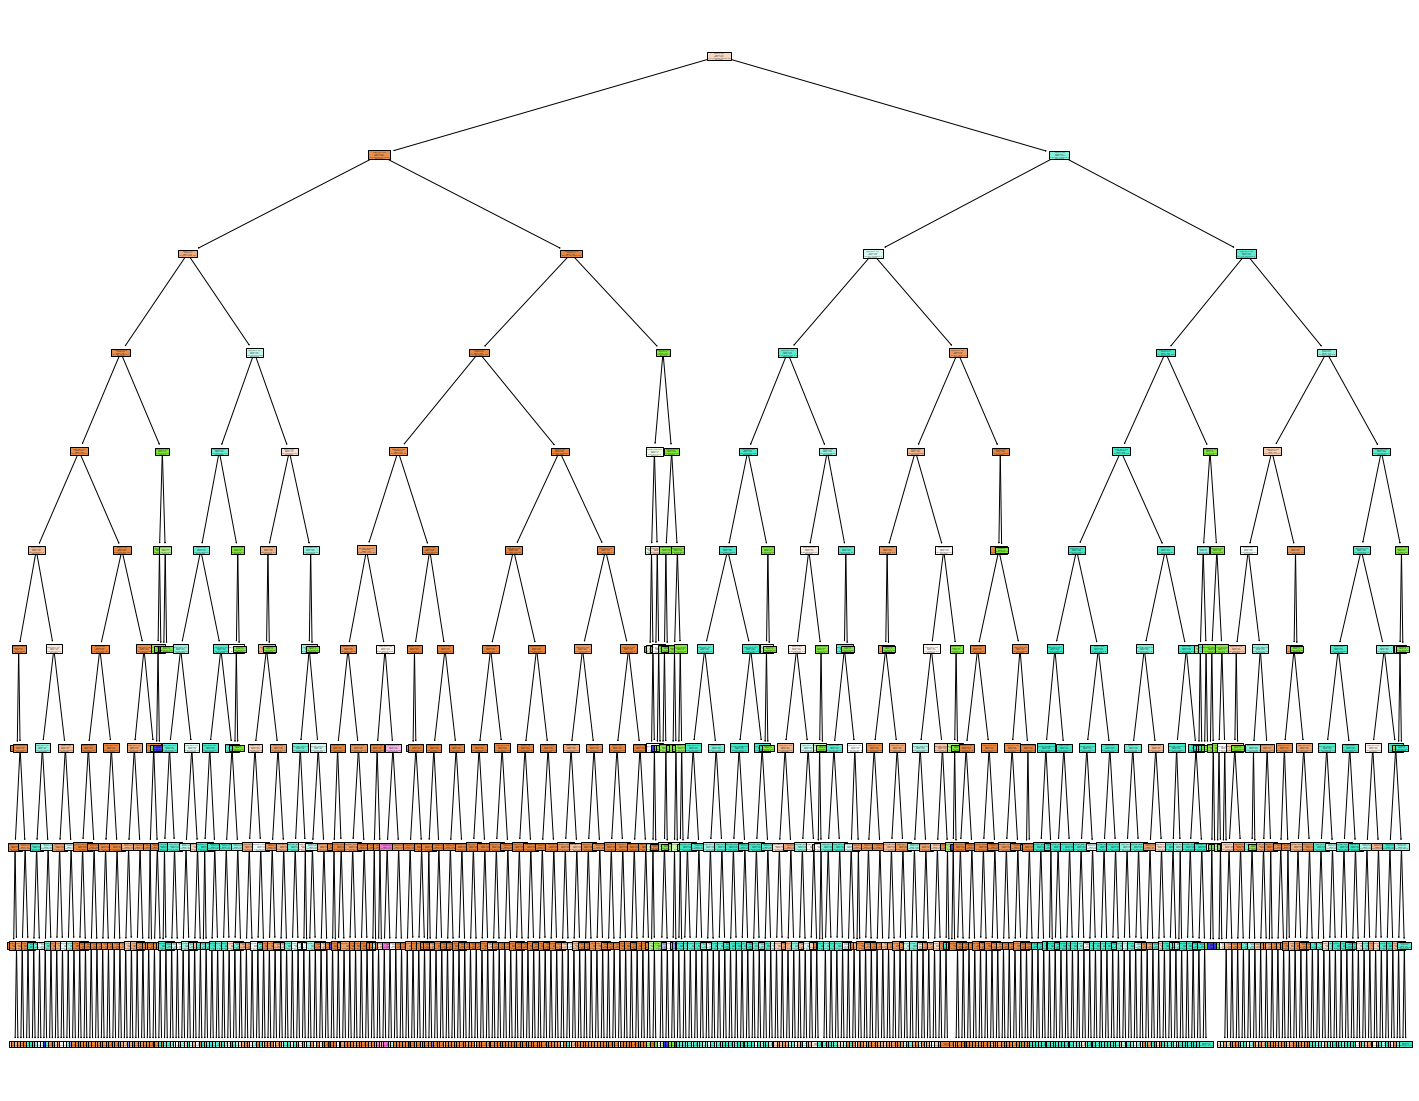

In [63]:
X = prepro1.fit_transform(X_train1)
y = y_train1
clf = DecisionTreeClassifier(max_depth = 10, criterion='entropy')
res = clf.fit(X, y)


enc1 = OneHotEncoder(categories=[mainCategory,currency],drop = 'first')
dum = enc1.fit_transform(X_train1[['main_category','currency']])
listFeat = enc1.get_feature_names(['main_category','currency']).tolist()
listContFeat = ['backers','usd_goal_real', 'nameLength', 'launchTime', 'deadlineTime', 'projectLength']
for i in listContFeat:
    listFeat.append(i)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf,
                   feature_names=listFeat,
                  class_names=['success','failed','undefined','live','suspended'],
                  filled=True)

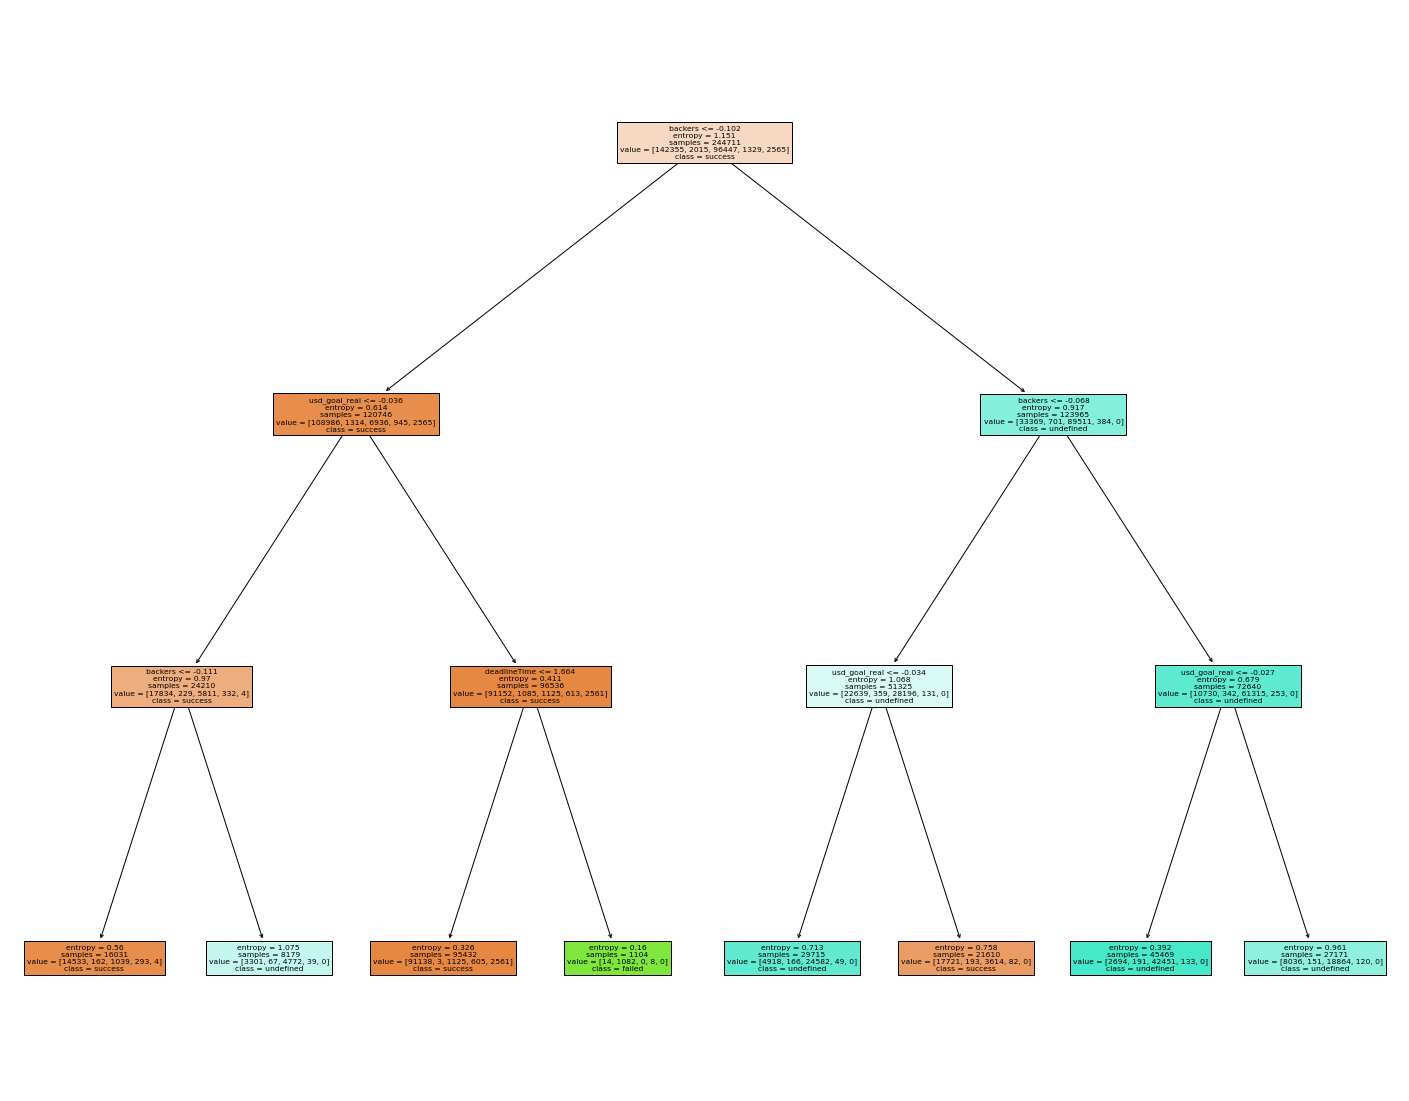

In [61]:
X = prepro1.fit_transform(X_train1)
y = y_train1
clf = DecisionTreeClassifier(max_depth = 3,criterion='entropy')
res = clf.fit(X, y)


enc1 = OneHotEncoder(categories=[mainCategory,currency],drop = 'first')
dum = enc1.fit_transform(X_train1[['main_category','currency']])
listFeat = enc1.get_feature_names(['main_category','currency']).tolist()
listContFeat = ['backers','usd_goal_real', 'nameLength', 'launchTime', 'deadlineTime', 'projectLength']
for i in listContFeat:
    listFeat.append(i)

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf,
                   feature_names=listFeat,
                  class_names=['success','failed','undefined','live','suspended'],
                  filled=True)

## Tests results

In [28]:
#df1 has all the thing needed for this part
dfS_test = df_test.copy()
dfS_test = dfS_test[['name','main_category','state', 'backers','usd_goal_real', 'nameLength', 'launchTime', 'deadlineTime', 'projectLength','currency']]
dfS_test = dfS_test[dfS_test['state'] != 'canceled']
dfS_test.shape


(33988, 10)

In [29]:
X_test1 = dfS_test.drop(columns=['state','name'])
y_test1 = dfS_test['state']
X_test2 = dfS_test.drop(columns=['state'])
y_test2 = dfS_test['state']

In [74]:
print(f'Test result for logistic without text feature = {model1.score(X_test1,y_test1)*100}')
print(f'Test result for logistic with text feature = {model2.score(X_test2,y_test2)*100}')
print(f'Test result for logistic with decision tree = {model4.score(X_test1,y_test1)*100}')

Test result for logistic without text feature = 88.67247263740143
Test result for logistic with text feature = 85.87442626809462
Test result for logistic with decision tree = 92.00894433329411


In [32]:
X_testConv1 = prepro1.fit_transform(X_test1).toarray()
X_testConv1 = np.reshape(X_testConv1, (X_testConv1.shape[0],X_testConv1.shape[1],1))

dum1 = OneHotEncoder(categories=[['successful','failed','undefined','live','suspended']]).fit(y_test1.values.reshape(-1,1))
y_testConv1 = dum1.transform(y_test1.values.reshape(-1,1)).toarray()

print(f'Test result for logistic with convolution network = {model3.evaluate(X_testConv1,y_testConv1)}')



1063/1063 [==============================] - 2s 2ms/step - loss: 0.9536 - accuracy: 0.8086
Test result for logistic with convolution network = [0.9535500407218933, 0.8085795044898987]
